#Upload and read the Excel file

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# 1. Upload and read the Excel file
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
raw = pd.read_excel(io.BytesIO(uploaded[file_name]), header=None)

# 2. Find all 'Method' header rows
header_rows = raw[raw.iloc[:, 0] == 'Method'].index.tolist()

# 3. Parse each data block into flat records
records = []
for h in header_rows:
    position = raw.iloc[h - 1, 0]
    cols = raw.iloc[h].tolist()
    for r in range(h+1, h+5):
        if r >= len(raw):
            break
        val = raw.iloc[r, 0]
        if pd.isna(val) or (isinstance(val, str) and (val == 'Method' or val.lower().startswith('pos-'))):
            break
        row = raw.iloc[r].tolist()
        rec = {'Position': position}
        for i, col in enumerate(cols):
            if pd.notna(col):
                rec[col] = row[i]
        records.append(rec)

df = pd.DataFrame(records)

Saving 36 locations.xlsx to 36 locations (8).xlsx


#Filter for Method

In [ ]:
m1 = df[df['Method'] == 'Method Origin'].copy()
image_title = 'Method Origin'

In [ ]:
m1 = df[df['Method'] == 'Method Elevation Correction'].copy()
image_title = 'Method Elevation Correction'

In [ ]:
m1 = df[df['Method'] == 'Method Offset Correction'].copy()
image_title = 'Method Offset Correction'

#Calculate and Draw

Combined CEP50 (all images): 13.13 m


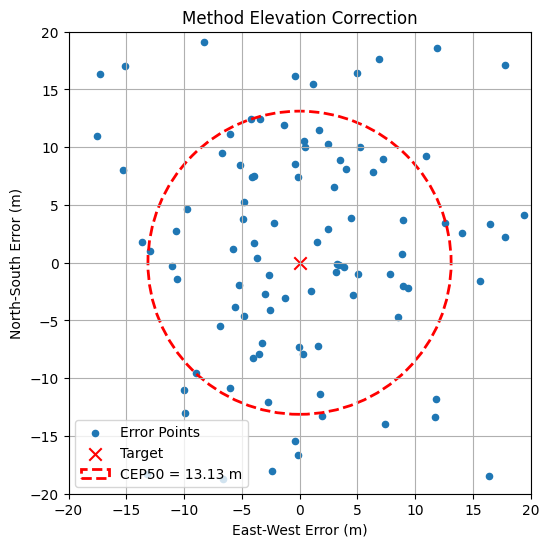

In [ ]:

# 5. Convert target coordinates to numeric
m1['target_lat'] = pd.to_numeric(m1['target_lat'], errors='coerce')
m1['target_lon'] = pd.to_numeric(m1['target_lon'], errors='coerce')

# 6. Precompute meters-per-degree factors at mean latitude
mean_lat = m1['target_lat'].mean()
m_per_deg_lat = 111320
m_per_deg_lon = 111320 * np.cos(np.deg2rad(mean_lat))

# 7. Collect all offsets from images 1–4
dx_all, dy_all = [], []
for img in [1, 2, 3, 4]:
    lat_col = next(c for c in m1.columns if c.startswith(f'img_{img}_') and 'lon' not in c)
    lon_col = next(c for c in m1.columns if c.startswith(f'img_{img}_') and 'lon' in c)

    m1[lat_col] = pd.to_numeric(m1[lat_col], errors='coerce')
    m1[lon_col] = pd.to_numeric(m1[lon_col], errors='coerce')

    dx = (m1[lon_col] - m1['target_lon']) * m_per_deg_lon
    dy = (m1[lat_col] - m1['target_lat']) * m_per_deg_lat
    dx_all.extend(dx)
    dy_all.extend(dy)

dx_all = np.array(dx_all)
dy_all = np.array(dy_all)

# 8. Compute CEP50 for all points
r_all = np.sqrt(dx_all**2 + dy_all**2)
r_all = r_all[~np.isnan(r_all)]
cep50_all = np.percentile(r_all, 50)
print(f"Combined CEP50 (all images): {cep50_all:.2f} m")

# 9. Plot combined scatter with CEP50 circle
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dx_all, dy_all, s=20, label='Error Points')
ax.scatter(0, 0, c='red', marker='x', s=80, label='Target')
circle = plt.Circle((0, 0), cep50_all, edgecolor='red',
                    fill=False, linestyle='--', linewidth=2,
                    label=f'CEP50 = {cep50_all:.2f} m')
ax.add_patch(circle)

# fixed_span = 10
# zoom_factor = 2
# R_zoom = cep50_all * zoom_factor
# R_display = max(fixed_span, R_zoom)
# ax.set_xlim(-R_display, R_display)
# ax.set_ylim(-R_display, R_display)

fixed_span = 20
ax.set_xlim(-fixed_span, fixed_span)
ax.set_ylim(-fixed_span, fixed_span)



ax.set_aspect('equal', 'box')
ax.set_xlabel('East-West Error (m)')
ax.set_ylabel('North-South Error (m)')
ax.set_title(image_title)
ax.legend()
ax.grid(True)
plt.show()


In [ ]:
# 4. List of methods to compare
methods = ['Method Origin', 'Method Elevation Correction', 'Method Offset Correction']
colors = ['blue', 'green', 'purple']
linestyles = ['--', '-.', ':']

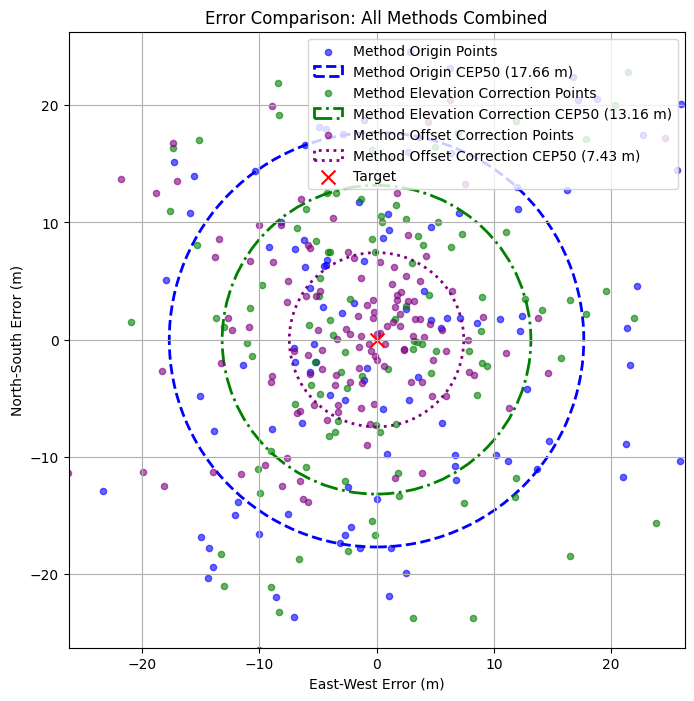

In [ ]:
# 5. Convert target coordinates to numeric
df['target_lat'] = pd.to_numeric(df['target_lat'], errors='coerce')
df['target_lon'] = pd.to_numeric(df['target_lon'], errors='coerce')

# 6. Compute meters-per-degree factors at the average latitude
mean_lat = df['target_lat'].mean()
m_per_deg_lat = 111320
m_per_deg_lon = 111320 * np.cos(np.deg2rad(mean_lat))

# 7. Collect dx/dy for each method across images 1–4 and compute CEP50
method_errors = {}
for method in methods:
    subset = df[df['Method'] == method].copy()
    dx_all, dy_all = [], []
    for img in [1, 2, 3, 4]:
        lat_col = next(c for c in subset.columns if c.startswith(f'img_{img}_') and 'lon' not in c)
        lon_col = next(c for c in subset.columns if c.startswith(f'img_{img}_') and 'lon' in c)
        subset[lat_col] = pd.to_numeric(subset[lat_col], errors='coerce')
        subset[lon_col] = pd.to_numeric(subset[lon_col], errors='coerce')
        dx = (subset[lon_col] - subset['target_lon']) * m_per_deg_lon
        dy = (subset[lat_col] - subset['target_lat']) * m_per_deg_lat
        mask = np.isfinite(dx) & np.isfinite(dy)
        dx_all.extend(dx[mask])
        dy_all.extend(dy[mask])
    dx_all = np.array(dx_all)
    dy_all = np.array(dy_all)
    r = np.sqrt(dx_all**2 + dy_all**2)
    cep50 = np.percentile(r, 50)
    method_errors[method] = {'dx': dx_all, 'dy': dy_all, 'cep50': cep50}

# 8. Determine axis limits
max_range = max(
    np.max(np.abs(err['dx'])) for err in method_errors.values()
)
max_range = max(max_range,
    np.max([err['cep50'] for err in method_errors.values()])) * 1.1

# 9. Plot combined scatter and CEP50 circles
fig, ax = plt.subplots(figsize=(8, 8))
for (method, err), color, ls in zip(method_errors.items(), colors, linestyles):
    ax.scatter(err['dx'], err['dy'], s=20, color=color, alpha=0.6, label=f'{method} Points')
    circle = plt.Circle((0, 0), err['cep50'], edgecolor=color,
                        fill=False, linestyle=ls, linewidth=2,
                        label=f'{method} CEP50 ({err["cep50"]:.2f} m)')
    ax.add_patch(circle)

# Plot target point
ax.scatter(0, 0, c='red', marker='x', s=100, label='Target')

zoom_factor = 2
R_zoom = cep50_all * zoom_factor
ax.set_xlim(-R_zoom, R_zoom)
ax.set_ylim(-R_zoom, R_zoom)

# 10. Finalize figure
# ax.set_xlim(-max_range, max_range)
# ax.set_ylim(-max_range, max_range)
ax.set_aspect('equal', 'box')
ax.set_xlabel('East-West Error (m)')
ax.set_ylabel('North-South Error (m)')
ax.set_title('Error Comparison: All Methods Combined')
ax.legend(loc='upper right')
ax.grid(True)
plt.show()